In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import cv2
import numpy as np
import numpy.linalg as npl
from matplotlib import pyplot as plt
from matplotlib import cbook
import ipywidgets as widgets
import time
import timeit

In [6]:
from helpers import apply_surface_lighting

In [89]:
EXAMPLE_DIR = 'gaming'
DEPTH_RES = 128
ON_SURFACE = False
PRINT_DEBUG = True

In [90]:
image = cv2.imread(f'./data/{EXAMPLE_DIR}/input.png')
depth = cv2.imread(f'./data/{EXAMPLE_DIR}/depth_metric_r20.png', cv2.IMREAD_ANYDEPTH)
normals = cv2.imread(f'./data/{EXAMPLE_DIR}/normals.png')
shading = cv2.imread(f'./data/{EXAMPLE_DIR}/ours_shd.png')
albedo = cv2.imread(f'./data/{EXAMPLE_DIR}/ours_alb.png')

# Preprocessing
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / np.max(image)

depth = np.array(depth / np.max(depth) * DEPTH_RES, dtype='uint8')
depth = DEPTH_RES - depth

# normals = cv2.cvtColor(normals, cv2.COLOR_BGR2RGB)
normals = ((normals / np.max(normals)) * 2) - 1

albedo = cv2.cvtColor(albedo, cv2.COLOR_BGR2RGB)
albedo = albedo / np.max(albedo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Mid Level Decomposition for "gaming"')

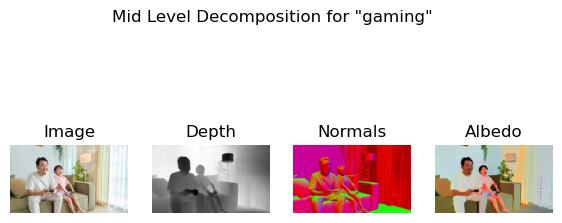

In [91]:
# Display image and mid-level image representations
fig, ax = plt.subplot_mosaic([['image', 'depth', 'normals', 'albedo']], figsize=(7, 3.5))
ax['image'].imshow(image)
ax['image'].axis('off')
ax['image'].set_title('Image')

ax['depth'].imshow(depth, cmap='gray')
ax['depth'].axis('off')
ax['depth'].set_title('Depth')

ax['normals'].imshow(normals)
ax['normals'].axis('off')
ax['normals'].set_title('Normals')

ax['albedo'].imshow(albedo)
ax['albedo'].axis('off')
ax['albedo'].set_title('Albedo')

fig.suptitle(f'Mid Level Decomposition for "{EXAMPLE_DIR}"')

## Refactor of **create_meshgrid**

In [92]:
# Refactored meshgrid, returns a flattened 2D RGB image, where R=x-coordinate, G=y-coordinate, B=z-coordinate
def create_flat_vector_field(depth_map, z_axis_resolution=128, return_full=False):
    if np.max(depth_map) != z_axis_resolution and np.min(depth_map) != 0:
        print(f"This should not print!")
        # Note: depth_map should be read using "cv2.imread('.', cv2.IMREAD_ANYDEPTH)"
        depth_map = np.array(depth_map / np.max(depth_map) * z_axis_resolution, dtype='uint8')
        depth_map = z_axis_resolution - depth_map  # Convert disparity map to depth map
    depth_map_x_dim, depth_map_y_dim = depth_map.shape
    x = np.arange(0, depth_map_x_dim)
    y = np.arange(0, depth_map_y_dim)
    z = np.arange(0, z_axis_resolution)

    xx, yy, zz = np.meshgrid(x, y, z, sparse=True)

    dense_x = np.ones((depth_map_y_dim, depth_map_x_dim, z_axis_resolution)) * xx
    dense_y = np.ones((depth_map_y_dim, depth_map_x_dim, z_axis_resolution)) * yy
    dense_z = np.ones((depth_map_y_dim, depth_map_x_dim, z_axis_resolution)) * zz

    vector_field = np.stack((dense_y, dense_x, dense_z), axis=-1)
    flat_vector_field = np.zeros((depth_map_y_dim, depth_map_x_dim, 3))
    # Works up to here
    for i in range(depth_map_y_dim):
        for j in range(depth_map_x_dim):
            d = depth[j, i] - 1
            v = vector_field[i, j, d]
            flat_vector_field[i, j] = v
    if return_full:
        return flat_vector_field, vector_field
    return flat_vector_field

In [95]:
# Tests for flat vector field
fvf = create_flat_vector_field(depth)
depth_map = depth - 1
test_coords = [[5, 5, depth_map[5, 5]], [715, 220, depth_map[625, 220]], [100, 100, depth_map[100, 100]], [550, 350, depth_map[550, 350]]]
print(test_coords)
print(fvf[5, 5], fvf[715, 220], fvf[100, 100], fvf[550, 350])

[[5, 5, 99], [715, 220, 23], [100, 100, 101], [550, 350, 39]]
[ 5.  5. 99.] [715. 220.  84.] [100. 100. 101.] [550. 350.  59.]


In [96]:
t0 = time.perf_counter()
flat_vec_field = create_flat_vector_field(depth)
t1 = time.perf_counter()
print(f"Meshgrid created in {t1-t0} seconds")

Meshgrid created in 7.818277344998933 seconds


## Refactor **get_surface_lighting** + **unit_direction_3D**

In [97]:
def point_light_3d(point, vector_field, attenuation_coef1=0., attenuation_coef2=0.005):
    directions_grid = vector_field - point
    magnitude = np.linalg.norm(directions_grid, axis=2)
    unit_direction_grid = directions_grid / magnitude[..., np.newaxis]
    magnitude_expanded = np.dstack([magnitude, magnitude, magnitude])
    attenuated_light = unit_direction_grid / (1 + (attenuation_coef1 * magnitude_expanded) + (attenuation_coef2 * magnitude_expanded**2))
    unit_direction_grid = np.swapaxes(unit_direction_grid, 0, 1)
    attenuated_light = np.swapaxes(attenuated_light, 0, 1)
    return unit_direction_grid, attenuated_light, magnitude


In [98]:
light_origin = np.array([250, 250, 0])

# Hardcoded shortcut to place light just on top of surface
if ON_SURFACE:
    light_origin[2] = depth[light_origin[0], light_origin[1]] - 16

t0 = time.perf_counter()
light_vector_field, attenuated_light ,light_magnitude_field = point_light_3d(light_origin, flat_vec_field)
t1 = time.perf_counter()
print(f"Vector field and Magnitude field created in {t1-t0} seconds")
print(f"{flat_vec_field[500, 250]}")

Vector field and Magnitude field created in 0.07276461199944606 seconds
[500. 250.  58.]


## Refactor of **apply_surface_lighting**

In [99]:
def calculate_shading(light_vectors, normals, light_colour=None):
    if light_colour is None:
        light_colour = [1, 1, 1]
    light_direction_times_normals = light_vectors * normals
    new_shading = np.sum(light_direction_times_normals, axis=2) / 3
    new_shading = np.dstack([new_shading, new_shading, new_shading]) * light_colour
    return new_shading

def apply_shading(shading, albedo, intensity=5):
    new_image = shading * albedo * intensity
    return new_image

In [100]:
lights = np.array([[150, 50, 0], [150, 100, 0], [150, 150, 0], [150, 200, 0], [150, 250, 0], [150, 300, 0], [150, 350, 0], [150, 400, 0], [150, 450, 0]])
shadings = []
shading_sum = np.zeros_like(image).astype('float64')
for light in lights:
    light_vectors = point_light_3d(light, flat_vec_field)[1]
    shading = calculate_shading(light_vectors, normals)
    shading_sum += np.abs(shading)
new_image = apply_shading(shading_sum, albedo, intensity=500)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1215.5, 703.5, -0.5)

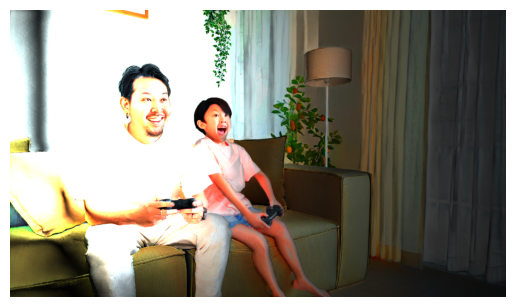

In [101]:
plt.imshow(new_image)
plt.axis('off')